## Sanity check of dataGenerator.py

In [25]:
cleanDataDir = '/home/mark/DataBank/PROBA-V-CHKPT'
arrayDir = os.path.join(cleanDataDir, 'arrayDir')
trimmedArrayDir = os.path.join(cleanDataDir, 'trimmedArrayDir')
patchesDir = os.path.join(cleanDataDir, 'patchesDir')
trimmedPatchesDir = os.path.join(cleanDataDir, 'trimmedPatchesDir')


def plot(img):
    plt.figure(figsize=[10,10])
    plt.imshow(img, cmap = 'gray', interpolation = 'none')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def plotLR(imgSet):
    fig, ax = plt.subplots(5, 5, figsize=[25,25])
    for j in range(5):
        for i in range(5):
            try:
                ax[j][i].imshow(imgSet[0, j*5 + i, 0, :, :], cmap = 'gray', interpolation = 'none')
                ax[j][i].set_xticks([]), ax[j][i].set_yticks([])
            except:
                break
    fig.tight_layout()
    
def plotPatchesLR(imgSet, imgnum=0):
    fig, ax = plt.subplots(4, 4, figsize=[16,16])
    for j in range(4):
        for i in range(4):
            try:
                ax[j][i].imshow(imgSet[0,j*4 + i, imgnum, 0, :, :], cmap = 'gray', interpolation = 'none')
                ax[j][i].set_xticks([]), ax[j][i].set_yticks([])
            except:
                break
    fig.tight_layout()

In [84]:
allImgLR, allMskLR, allImgHR, allMskHR = TRAIN


In [86]:
allImgLR = np.array([allImgLR[0]])
allMskLR = np.array([allMskLR[0]])
allImgHR = np.array([allImgHR[0]])
allMskHR = np.array([allMskHR[0]])
allImgLR.shape

(1, 21, 1, 128, 128)

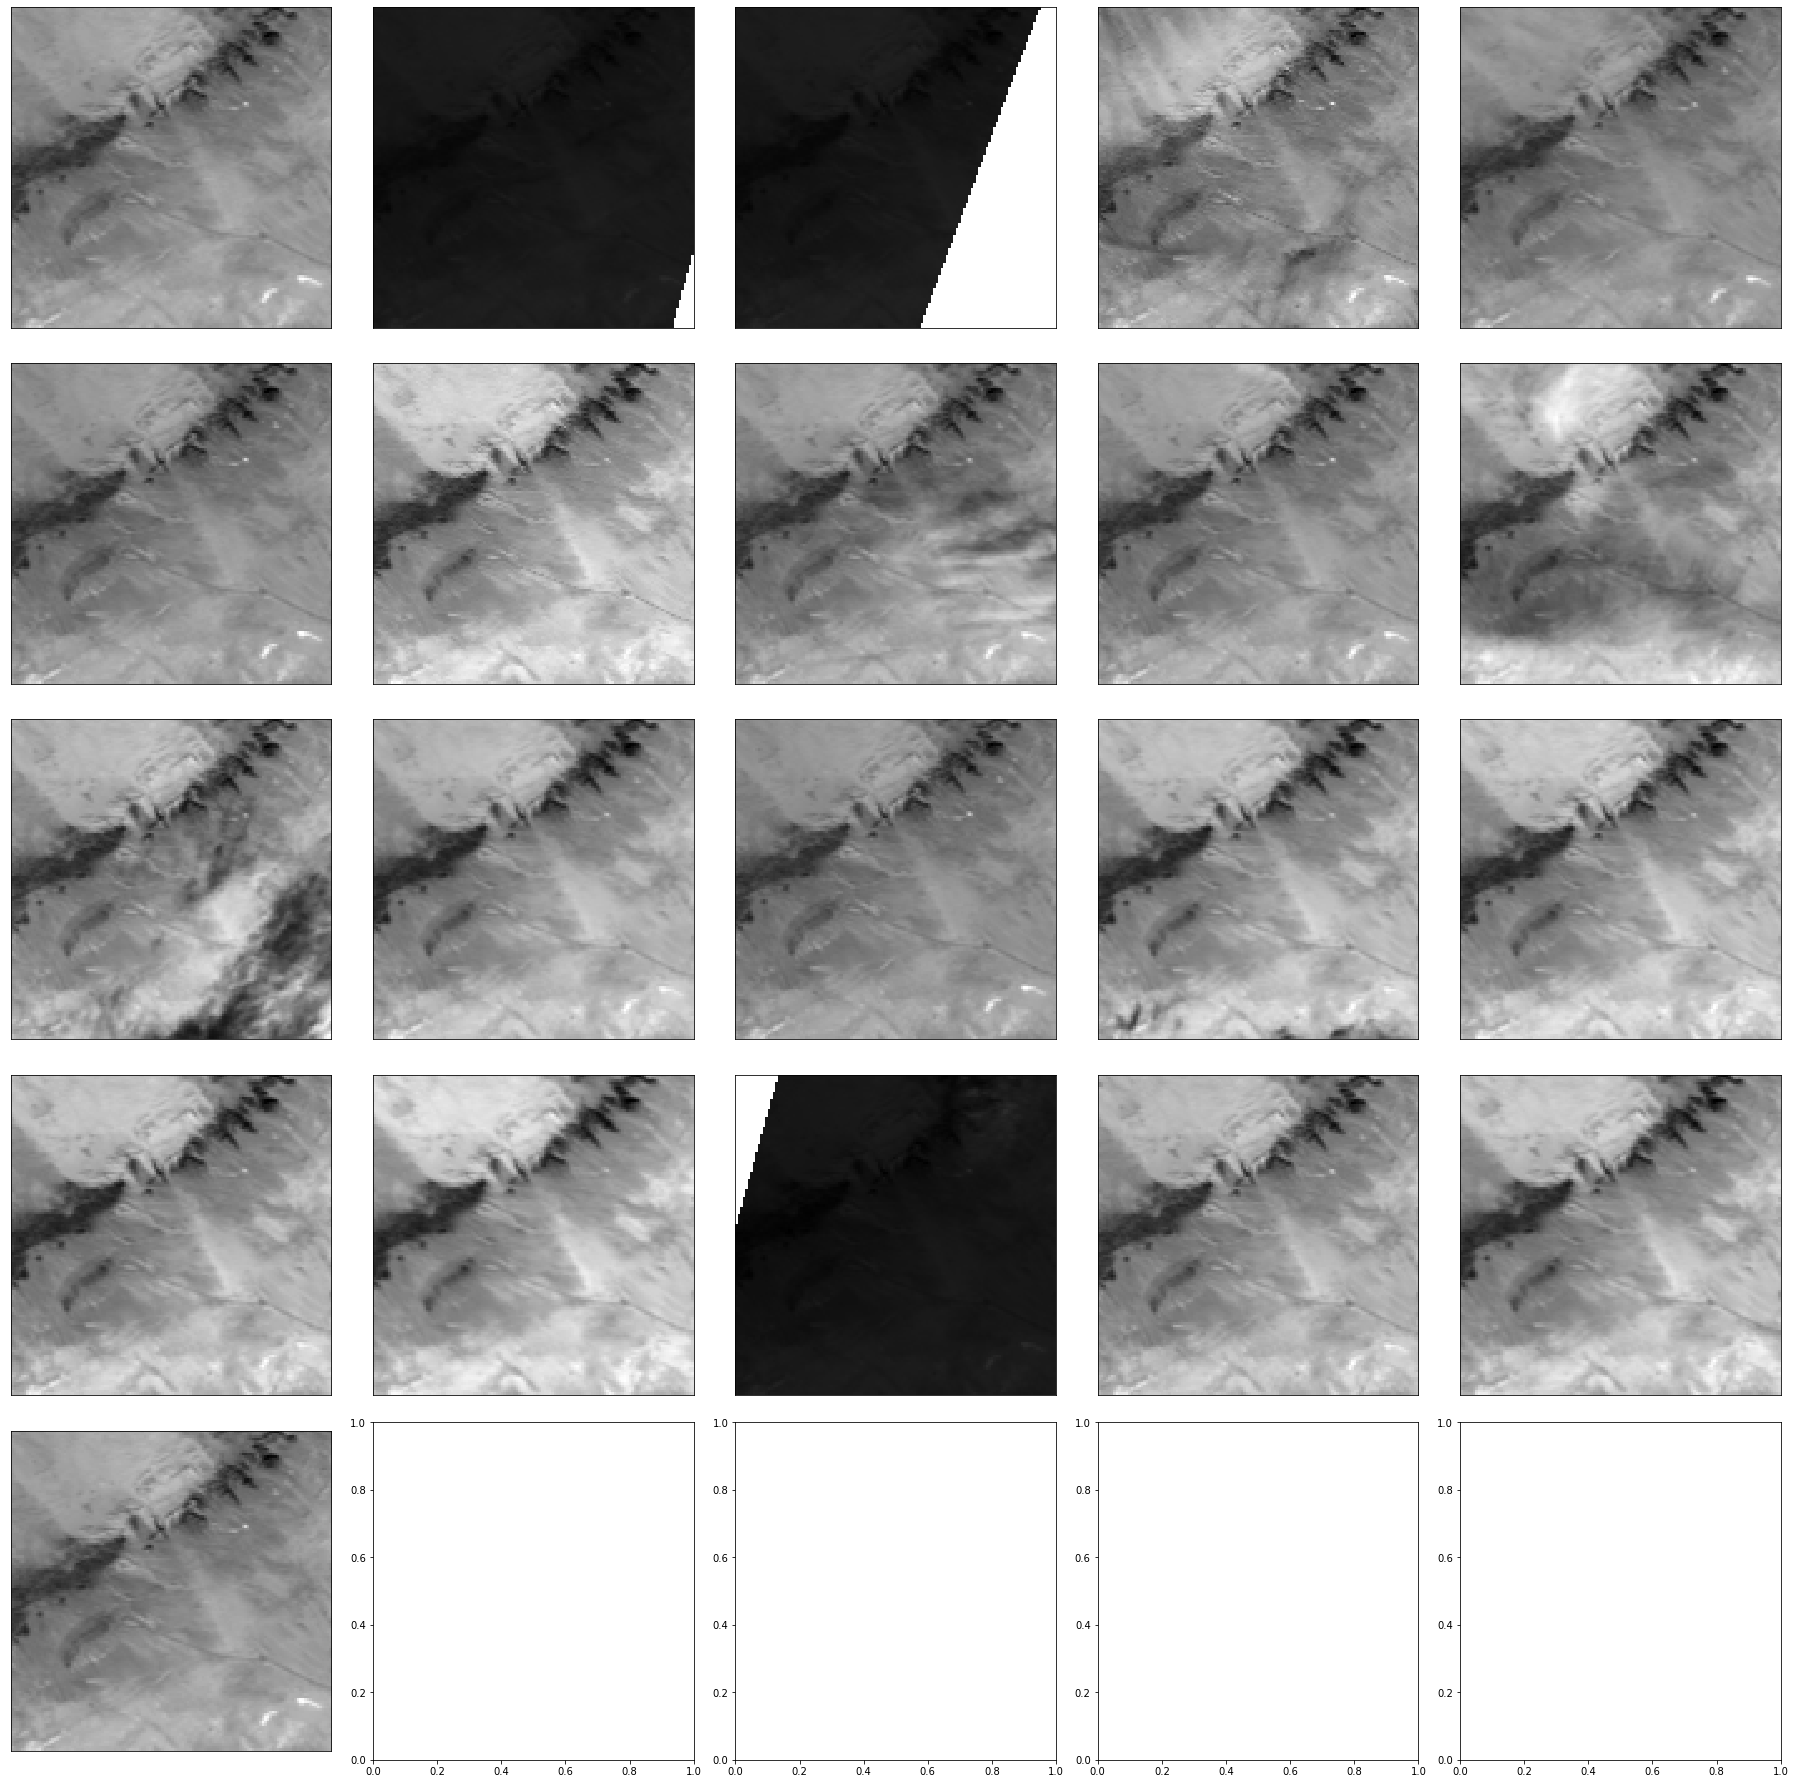

In [124]:
plotLR(allImgLR)

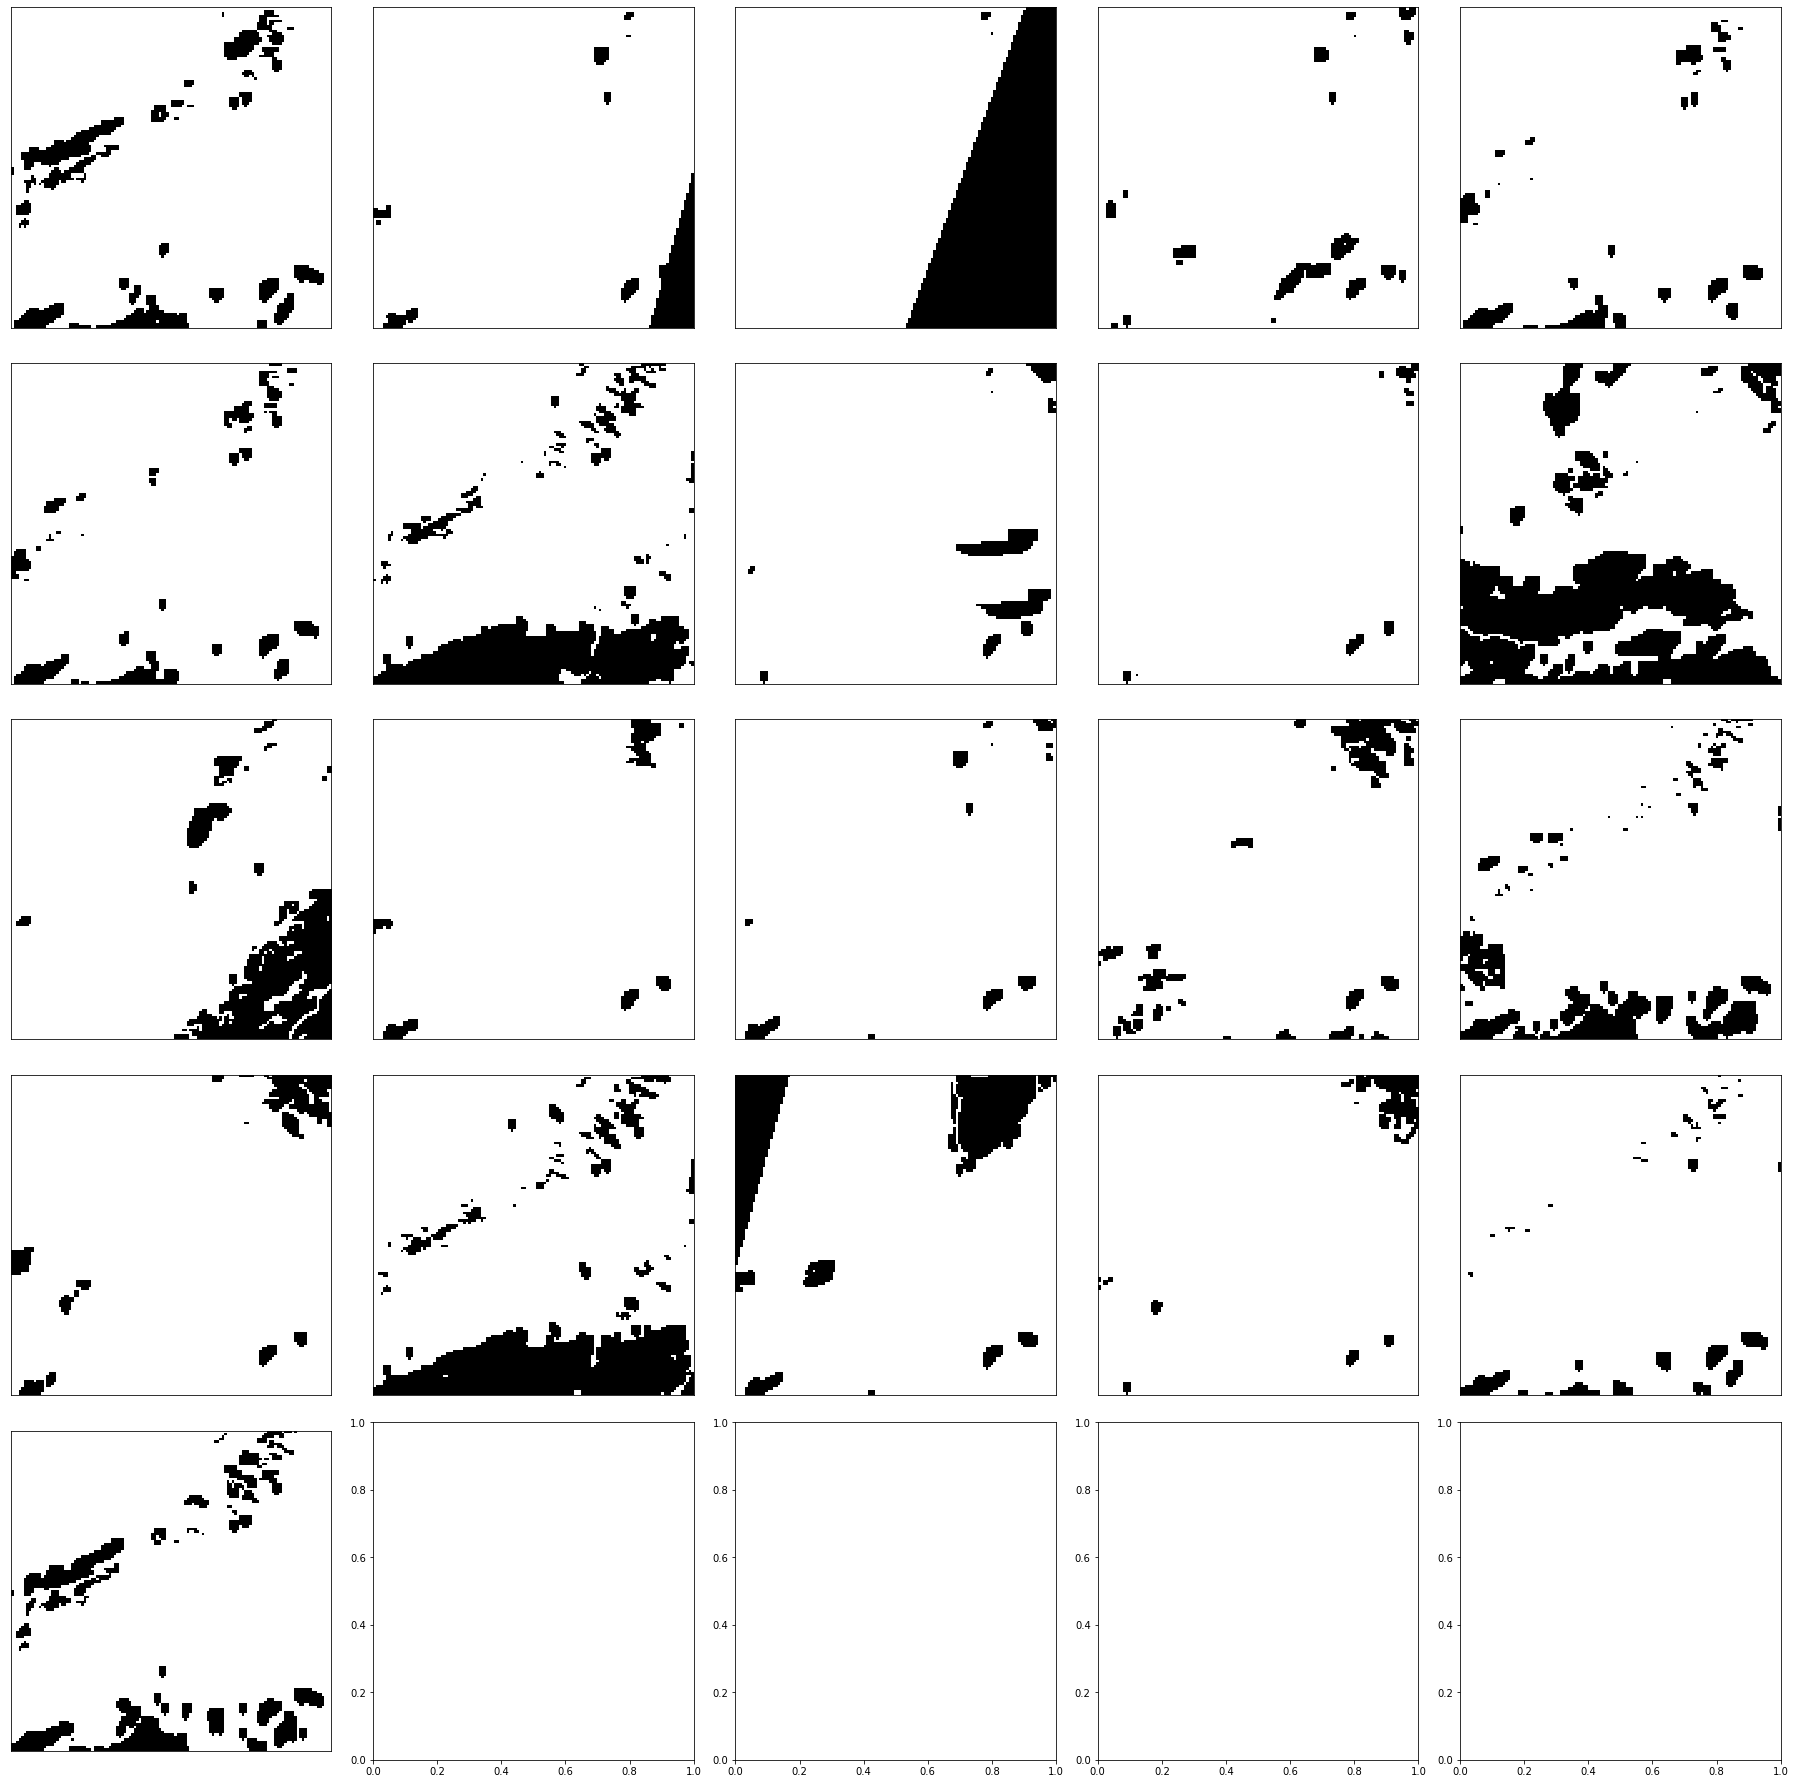

In [126]:
plotLR(allMskLR)

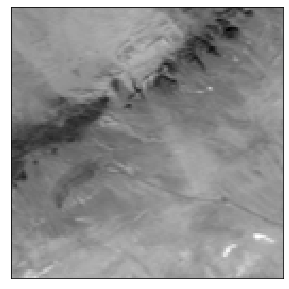

In [87]:
plot(allImgLR[0, 0, 0])

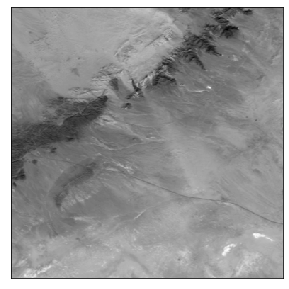

In [88]:
plot(allImgHR[0, 0, 0])

## Register images

In [137]:
allImgMskLR = registerImages(allImgLR, allMskLR)


[ INFO ] Registering LR images         : 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


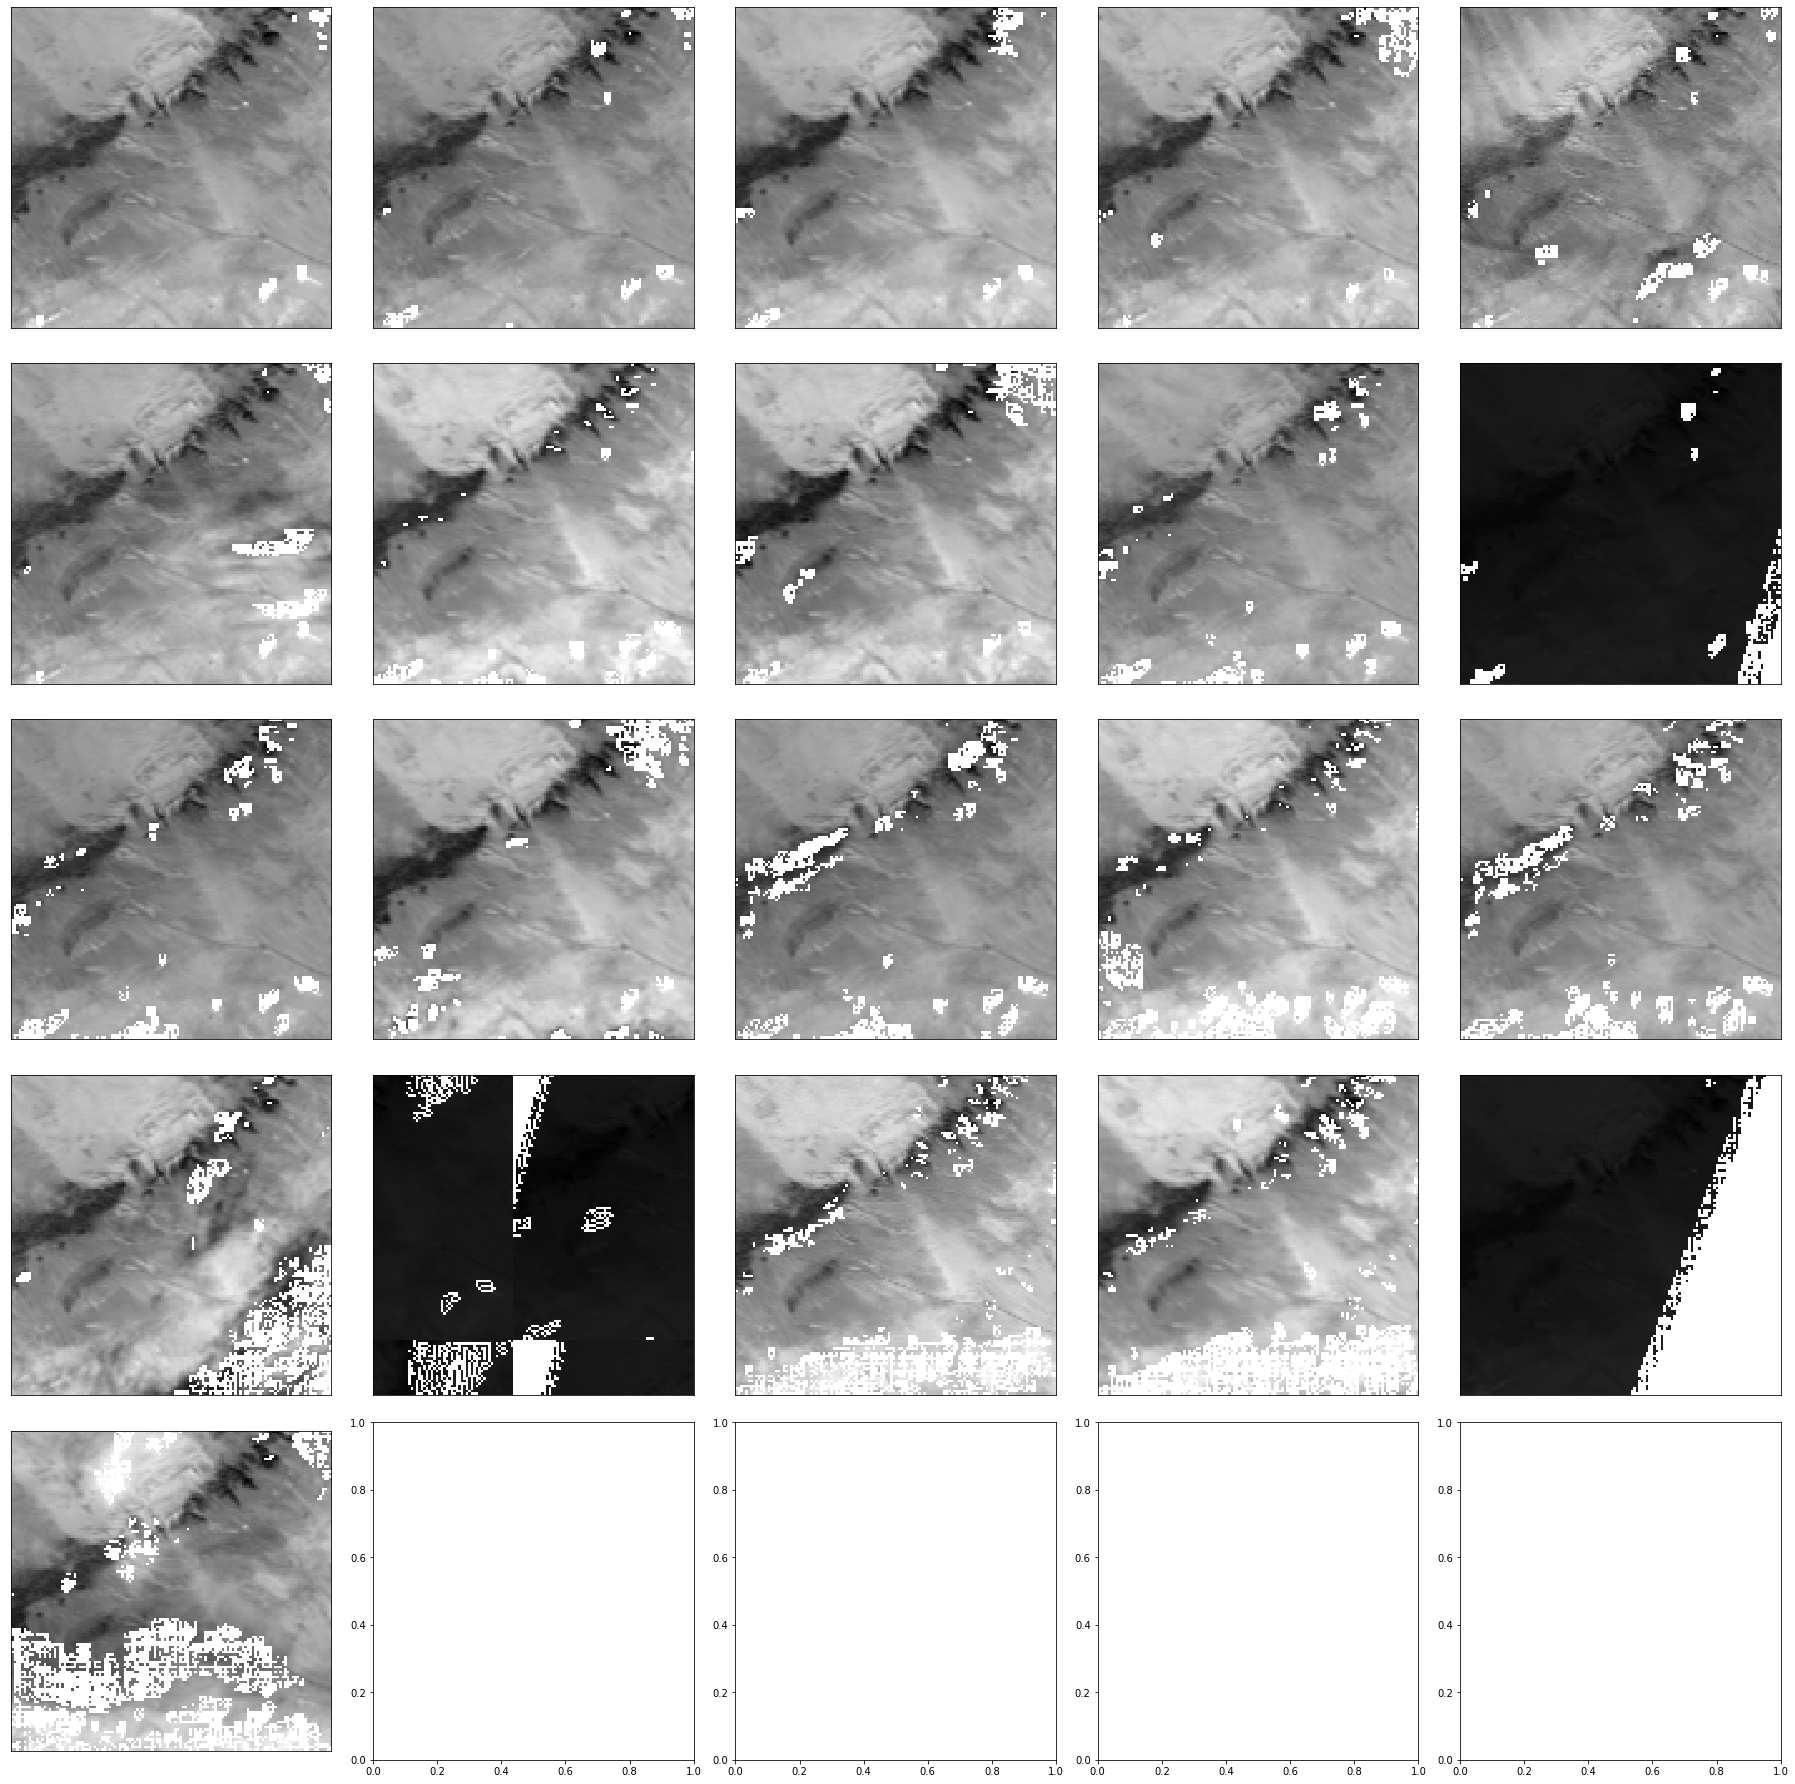

In [138]:
plotLR(allImgMskLR)

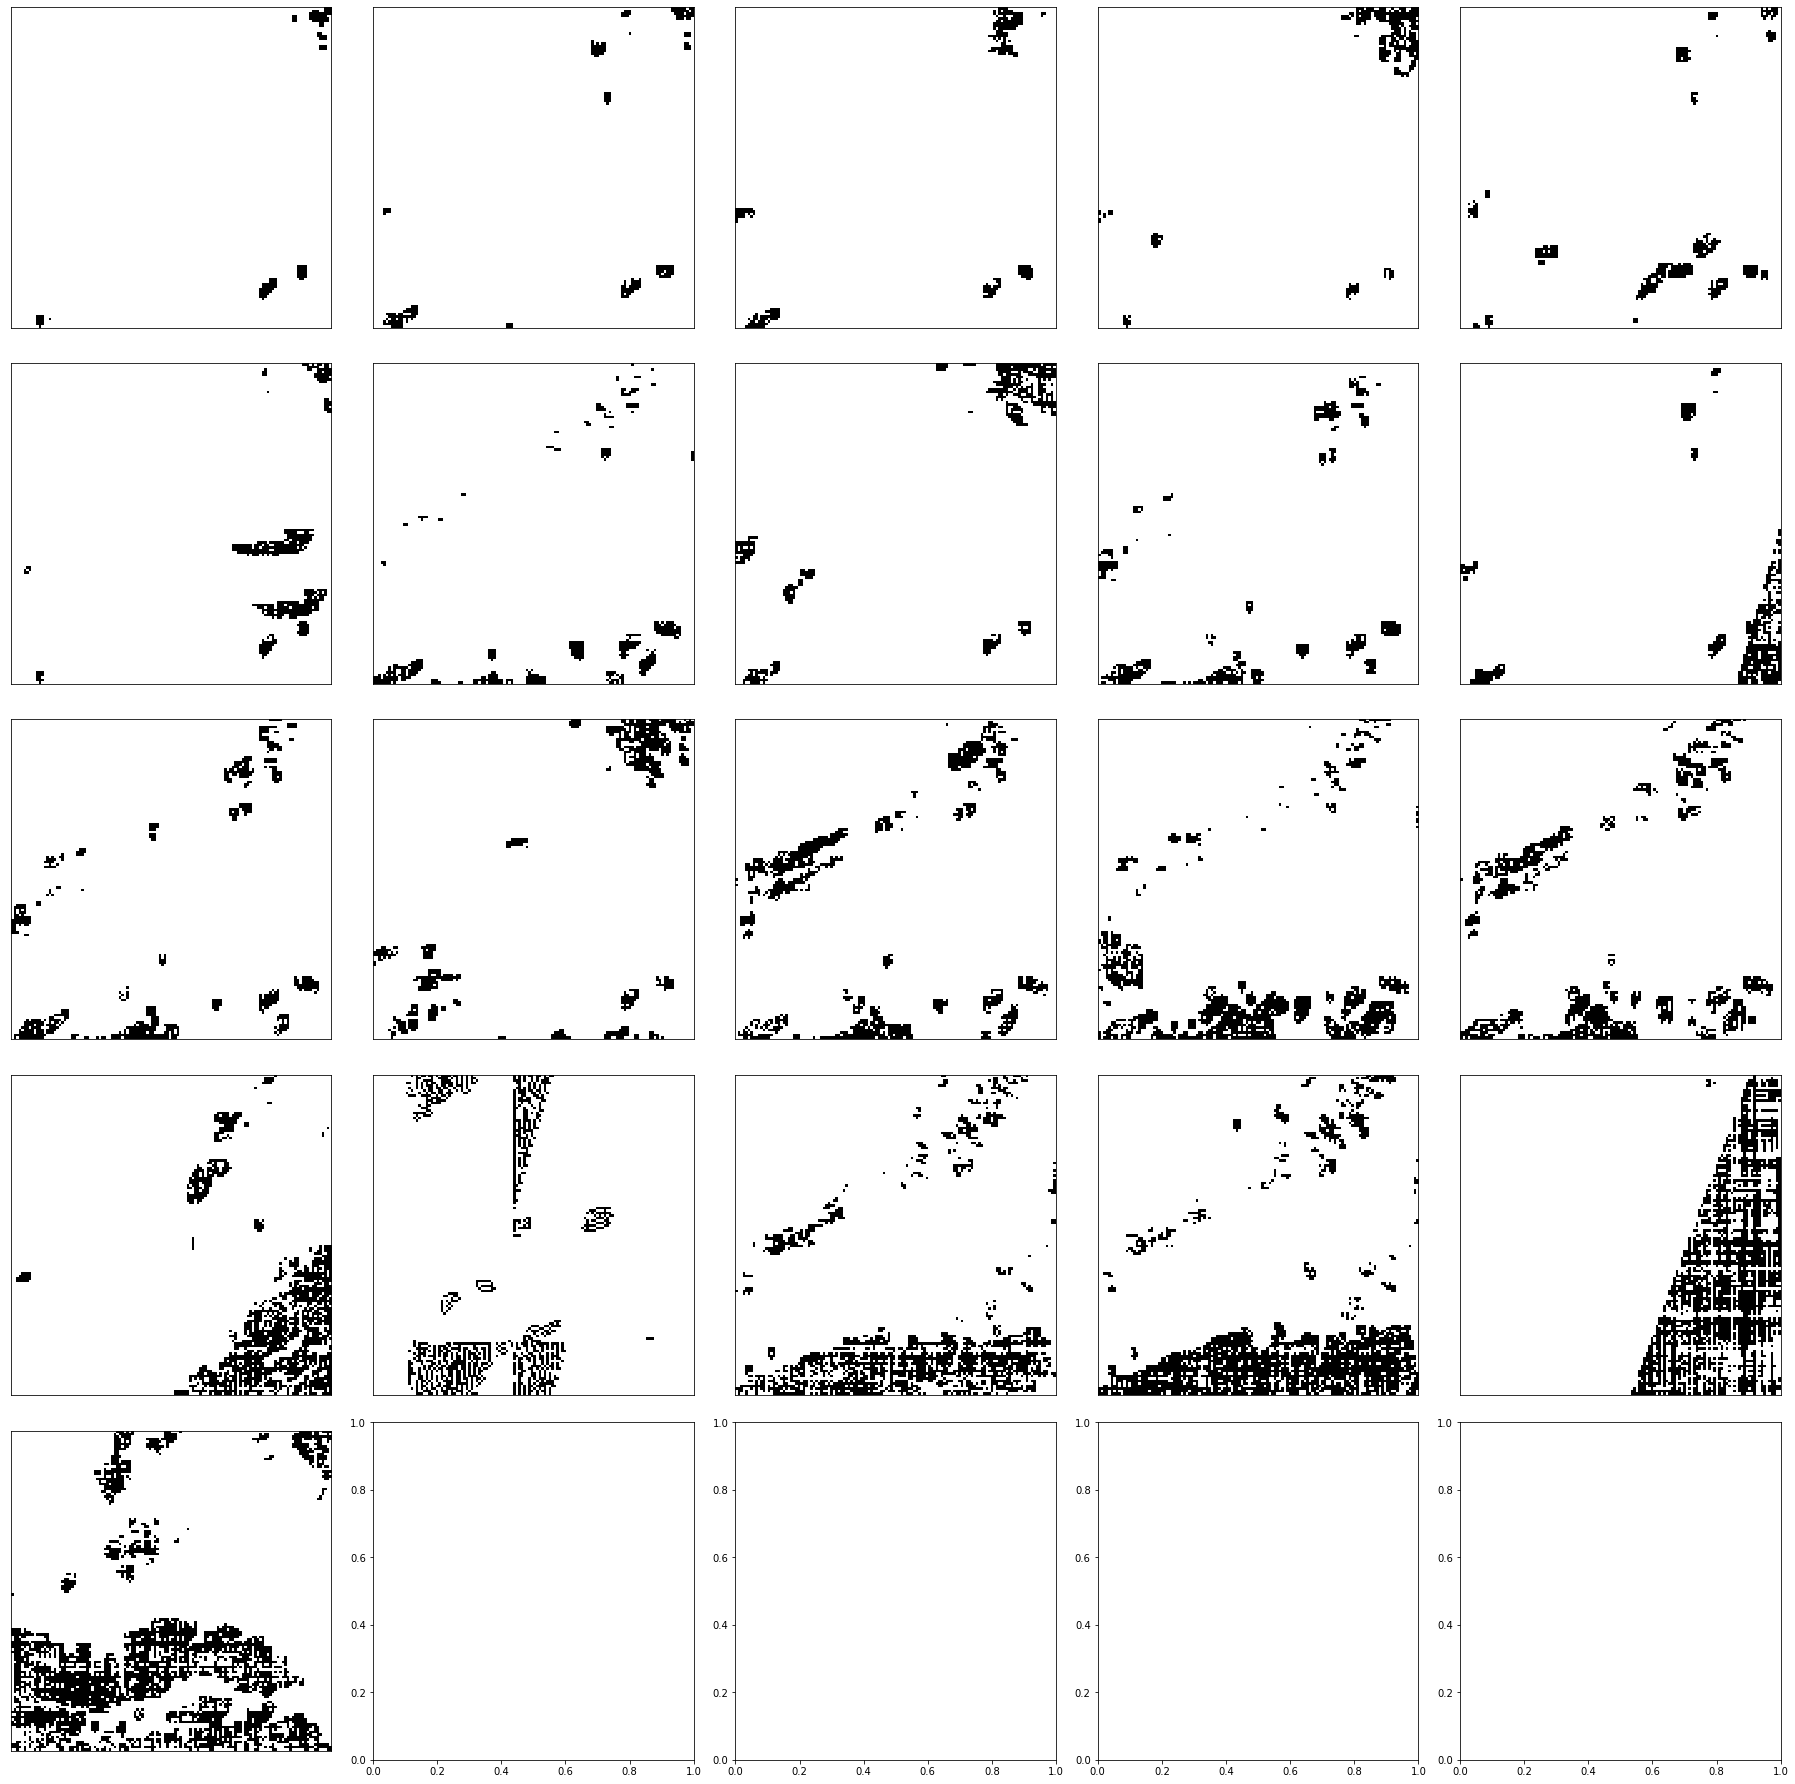

In [139]:
plotLR(~allImgMskLR.mask)

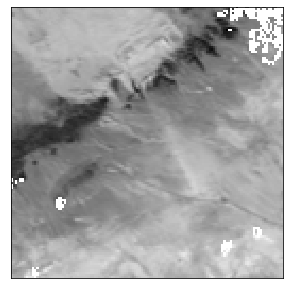

In [140]:
plot(allImgMskLR[0, 3, 0])

In [161]:
allImgMskHR = convertToMaskedArray(allImgHR, allMskHR)

In [162]:
allImgMskHR.shape

(1, 1, 1, 384, 384)

In [164]:
trmImgMskLR, trmImgMskHR = removeCorruptedTrainImageSets(
            allImgMskLR, allImgMskHR, clarityThreshold=0.7)
trmImgMskLR = pickClearLRImgsPerImgSet(
            trmImgMskLR, numImgToPick=9, clarityThreshold=0.7)


[ INFO ] Removing corrupted ImageSets  : 100%|██████████| 1/1 [00:00<00:00, 1562.12it/s]

[ INFO ] Picking top 9 clearest images : 100%|██████████| 1/1 [00:00<00:00, 493.56it/s]


In [159]:
trmImgMskLR.shape

(1, 21, 1, 128, 128)

In [165]:
numImgSet, numImgPerImgSet, C, H, W = trmImgMskLR.shape
patchesLR = generatePatches(trmImgMskLR, patchSize=32, stride=32)
patchesLR = patchesLR.reshape((numImgSet, -1, numImgPerImgSet, C, 32, 32))


[ INFO ] Generating patches (k=32, s=32): 100%|██████████| 1/1 [00:00<00:00, 735.84it/s]


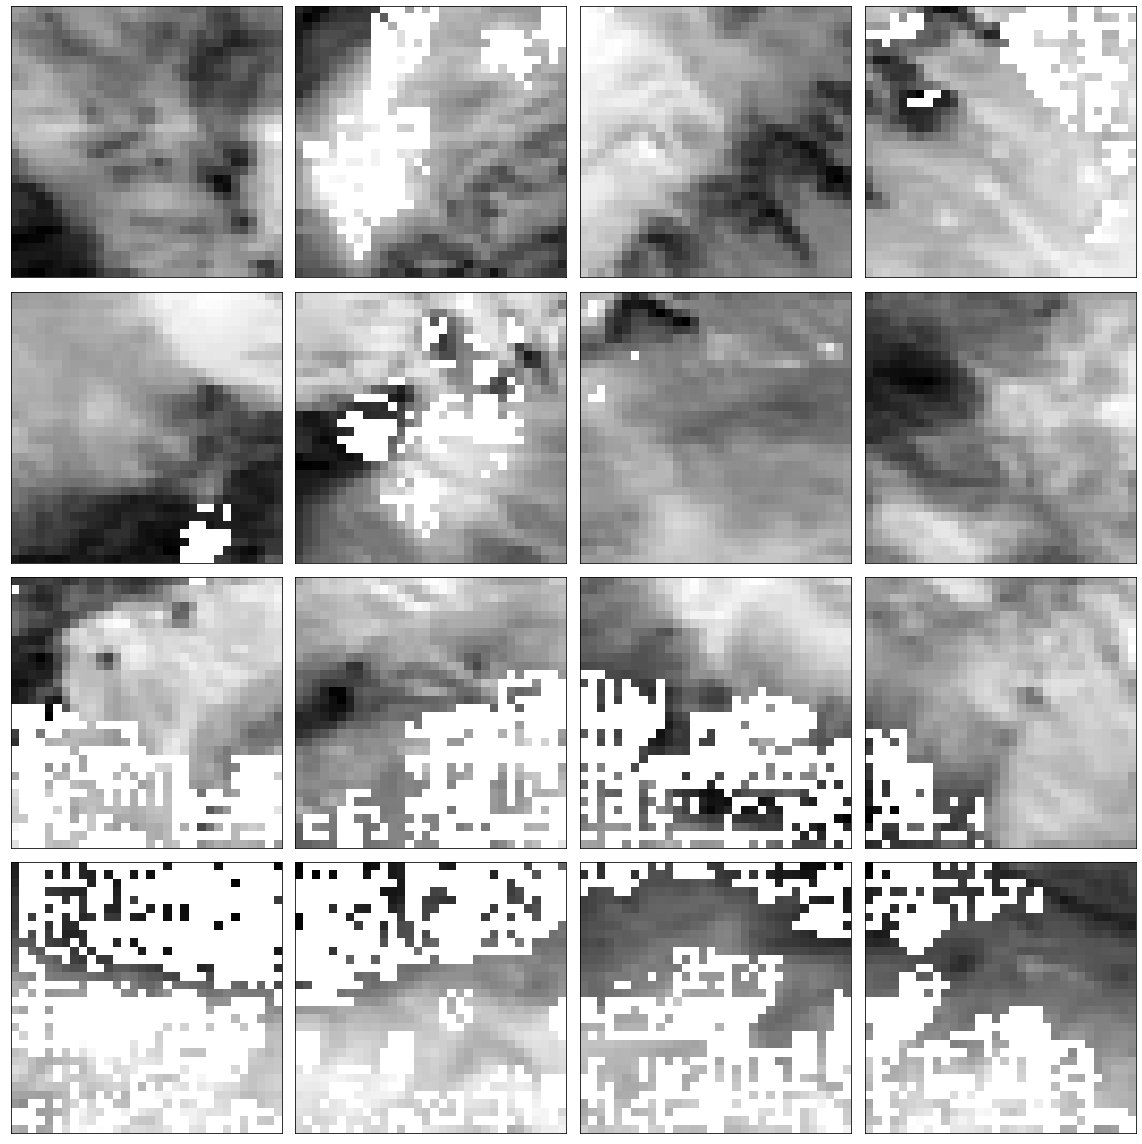

In [167]:
plotPatchesLR(patchesLR)

In [169]:
numImgSet, numImgPerImgSet, C, Hhr, Whr = trmImgMskHR.shape
        # Compute upsampleScale
upsampleScale = Hhr // H
patchesHR = generatePatches(trmImgMskHR, patchSize=32*
                            upsampleScale, stride=32* upsampleScale)
patchesHR = patchesHR.reshape((numImgSet, -1, numImgPerImgSet, C, 32 *
                               upsampleScale, 32 * upsampleScale))


[ INFO ] Generating patches (k=96, s=96): 100%|██████████| 1/1 [00:00<00:00, 2089.84it/s]


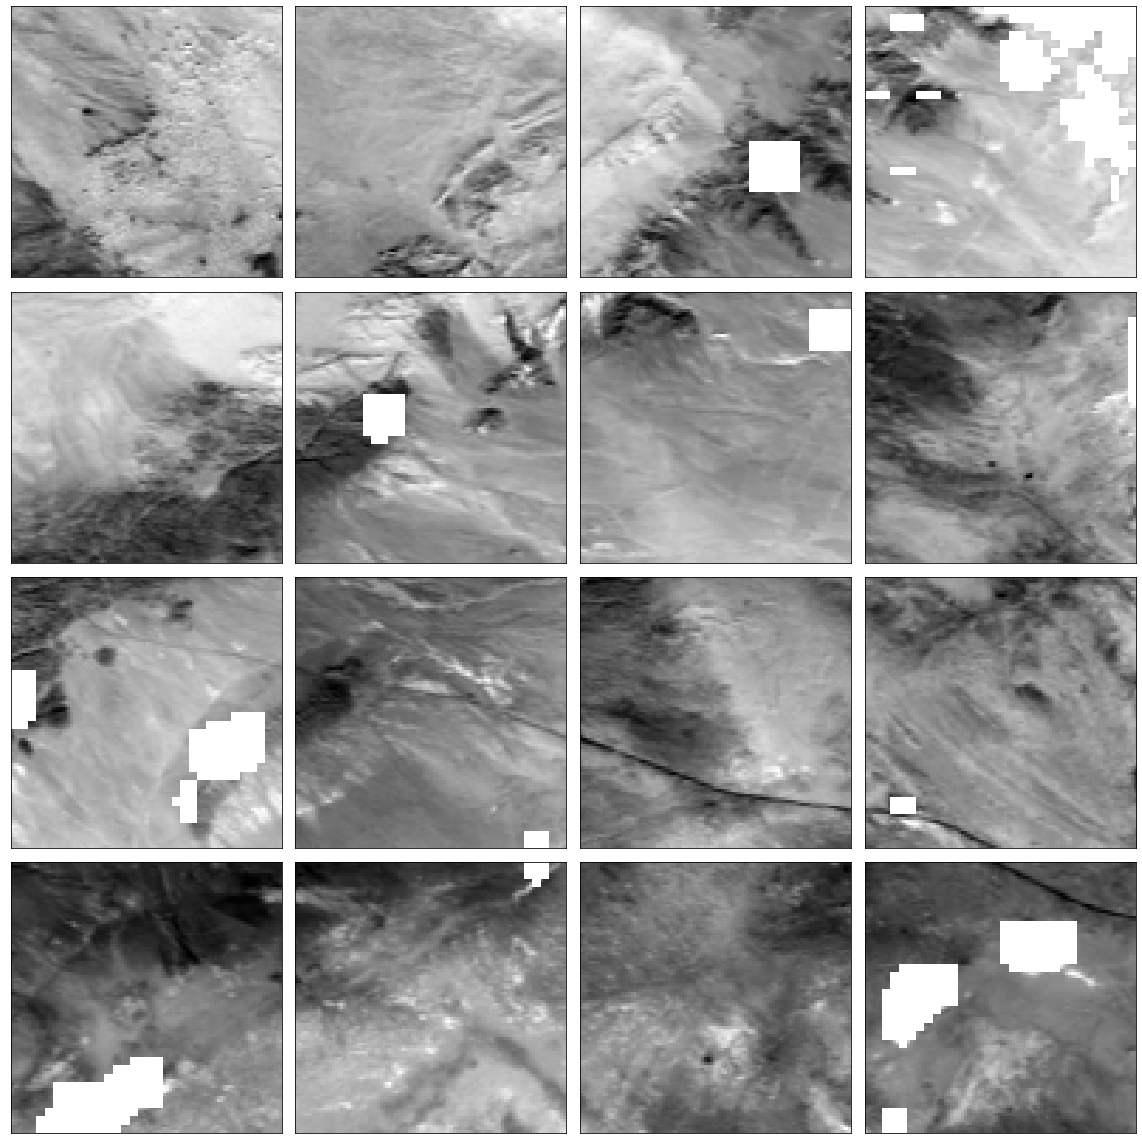

In [170]:
plotPatchesLR(patchesHR)

In [191]:
trmPatchesLR, trmPatchesHR = removeCorruptedTrainPatchSets(
    patchesLR, patchesHR, clarityThreshold=0.85)


[ INFO ] Removing corrupted train sets : 100%|██████████| 1/1 [00:00<00:00, 2516.08it/s]


In [192]:
trmPatchesHR.shape

(1, 16, 1, 1, 96, 96)

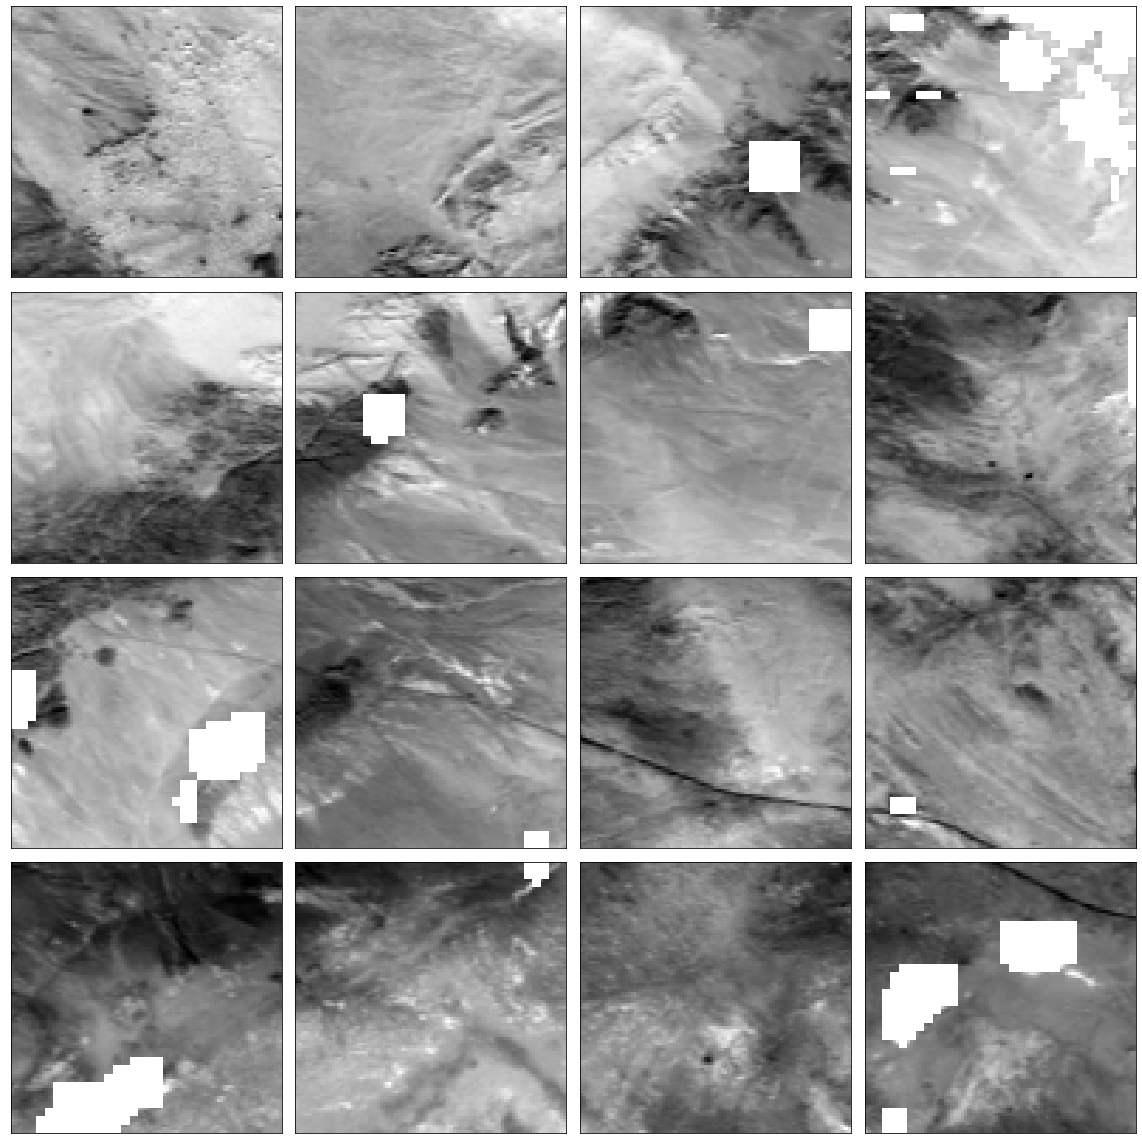

In [193]:
plotPatchesLR(trmPatchesHR)

In [173]:
trmPatchesLR.shape

(1, 16, 9, 1, 32, 32)

In [194]:
trmPatchesLR, trmPatchesHR = pickClearPatches(
    trmPatchesLR, trmPatchesHR, clarityThreshold=0.85)


[ INFO ] Cleaning train patches        : 100%|██████████| 16/16 [00:00<00:00, 21420.00it/s]


In [178]:
trmPatchesHR.shape

(12, 1, 1, 96, 96)

In [175]:
trmPatchesLR.shape

(12, 9, 1, 32, 32)

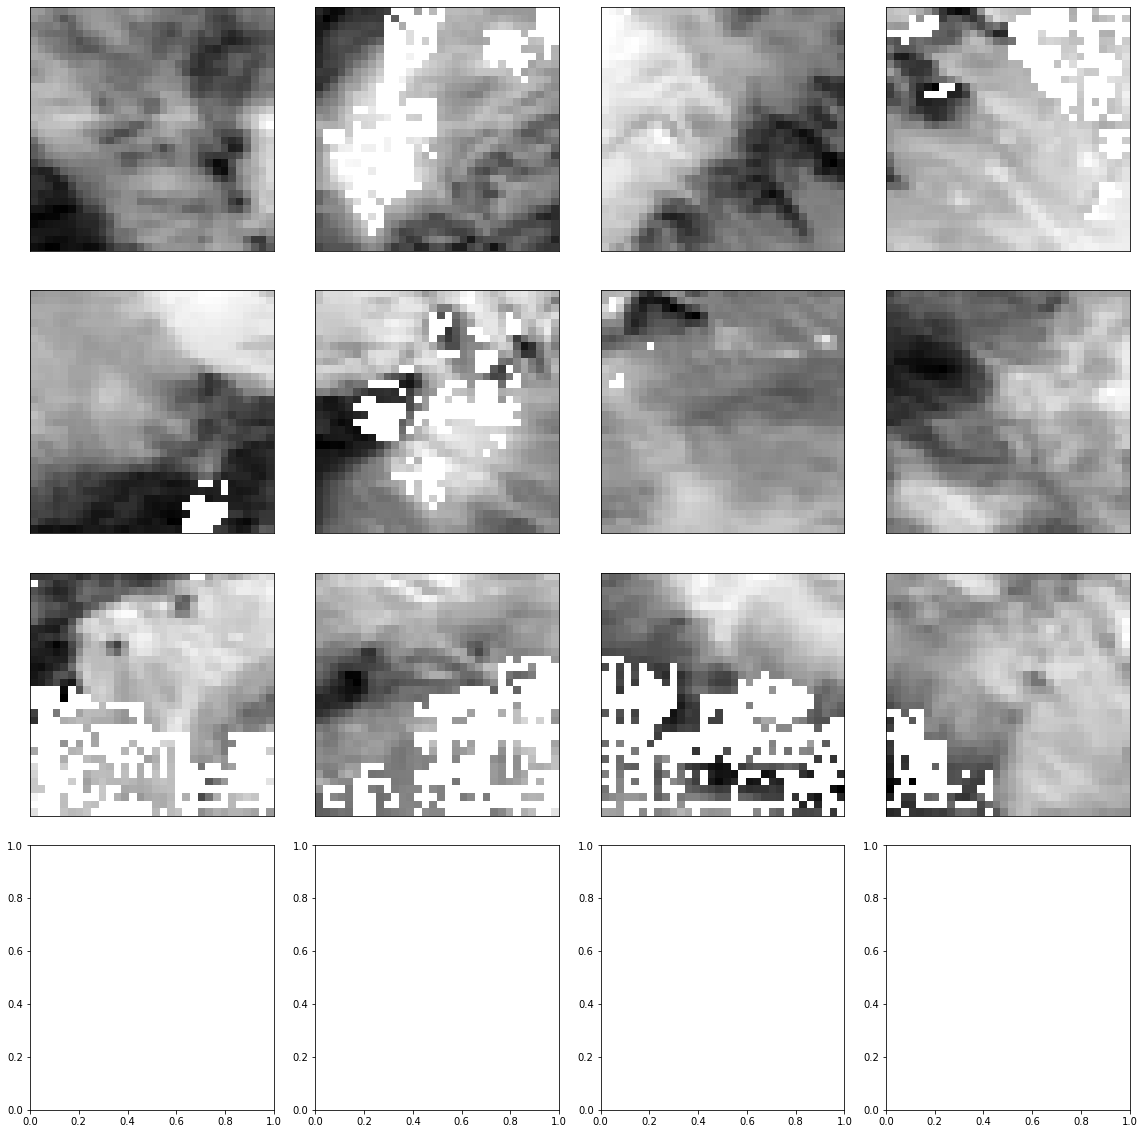

In [177]:
plotPatchesLR(np.expand_dims(trmPatchesLR, axis=0))

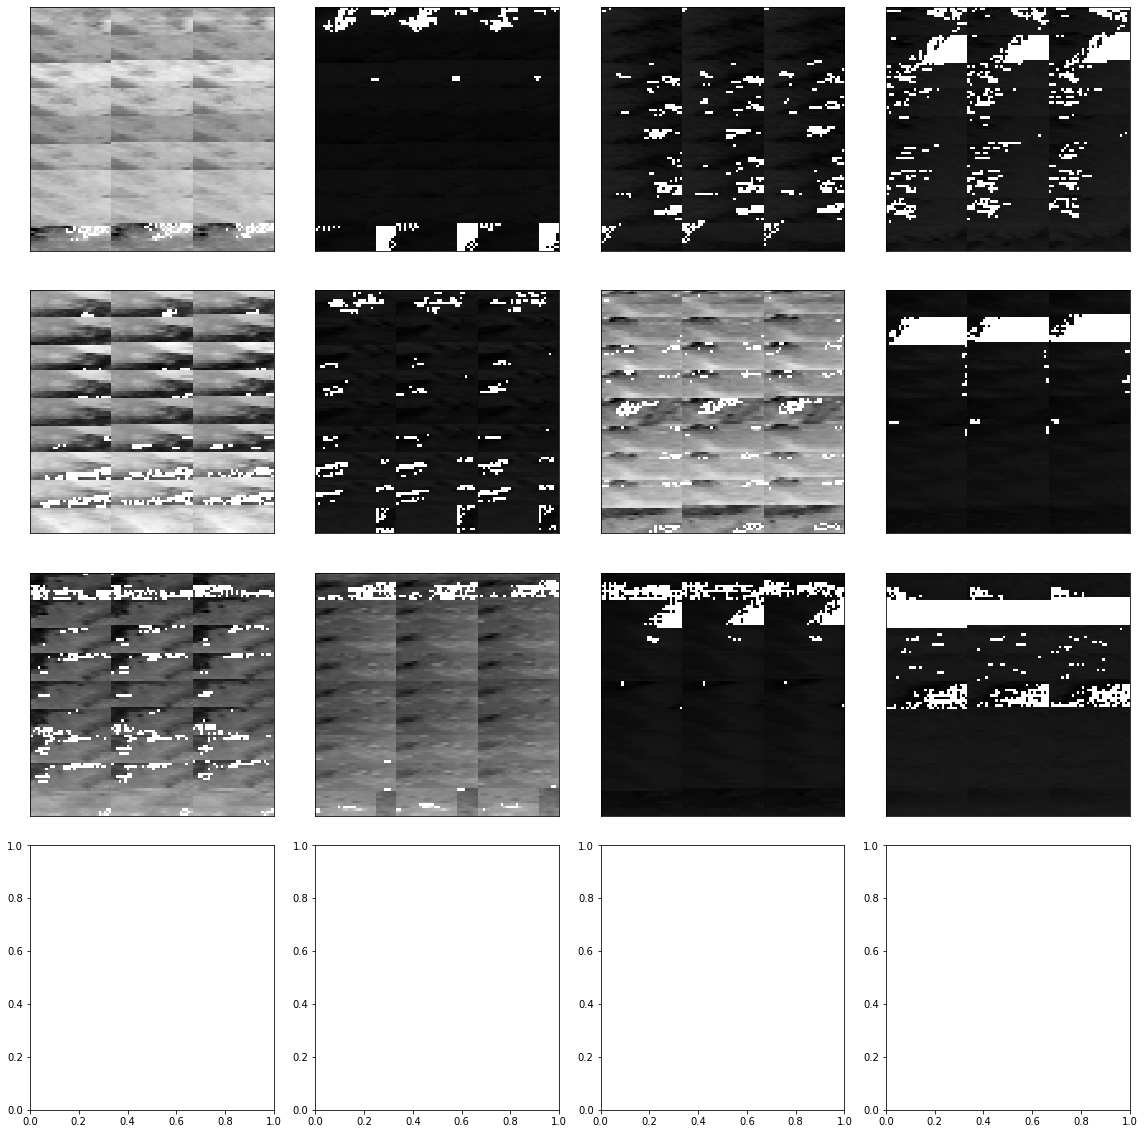

In [195]:
plotPatchesLR(np.expand_dims(trmPatchesHR, axis=0))

In [ ]:
trmPatchesLR = trmPatchesLR.transpose((0, 3, 4, 1, 2))  # shape is (numImgSet, H, W, numLRImg, C)
trmPatchesHR = trmPatchesHR.transpose((0, 3, 4, 1, 2))
trmPatchesHR = trmPatchesHR.squeeze(4)

In [196]:
# import data
CLEAN_DATA_DIR = '/home/mark/DataBank/PROBA-V-CHKPT/trimmedPatchesDir'
band = 'NIR'
X = np.load(os.path.join(CLEAN_DATA_DIR, f'TRAINpatchesLR_{band}.npy'), allow_pickle=True)
y = np.load(os.path.join(CLEAN_DATA_DIR, f'TRAINpatchesHR_{band}.npy'), allow_pickle=True)

#X = X_train.transpose((0, 3, 4, 2, 1))
#y = y_train.transpose((0, 3, 4, 2, 1)).squeeze(3)
print(f'Input shape: {X.shape} --------> Output shape: {y.shape}')

Input shape: (8240, 32, 32, 9, 1) --------> Output shape: (8240, 96, 96, 1)


In [197]:
np.expand_dims(X.transpose((0, 3, 4, 1, 2)), axis=0).shape

(1, 8240, 9, 1, 32, 32)

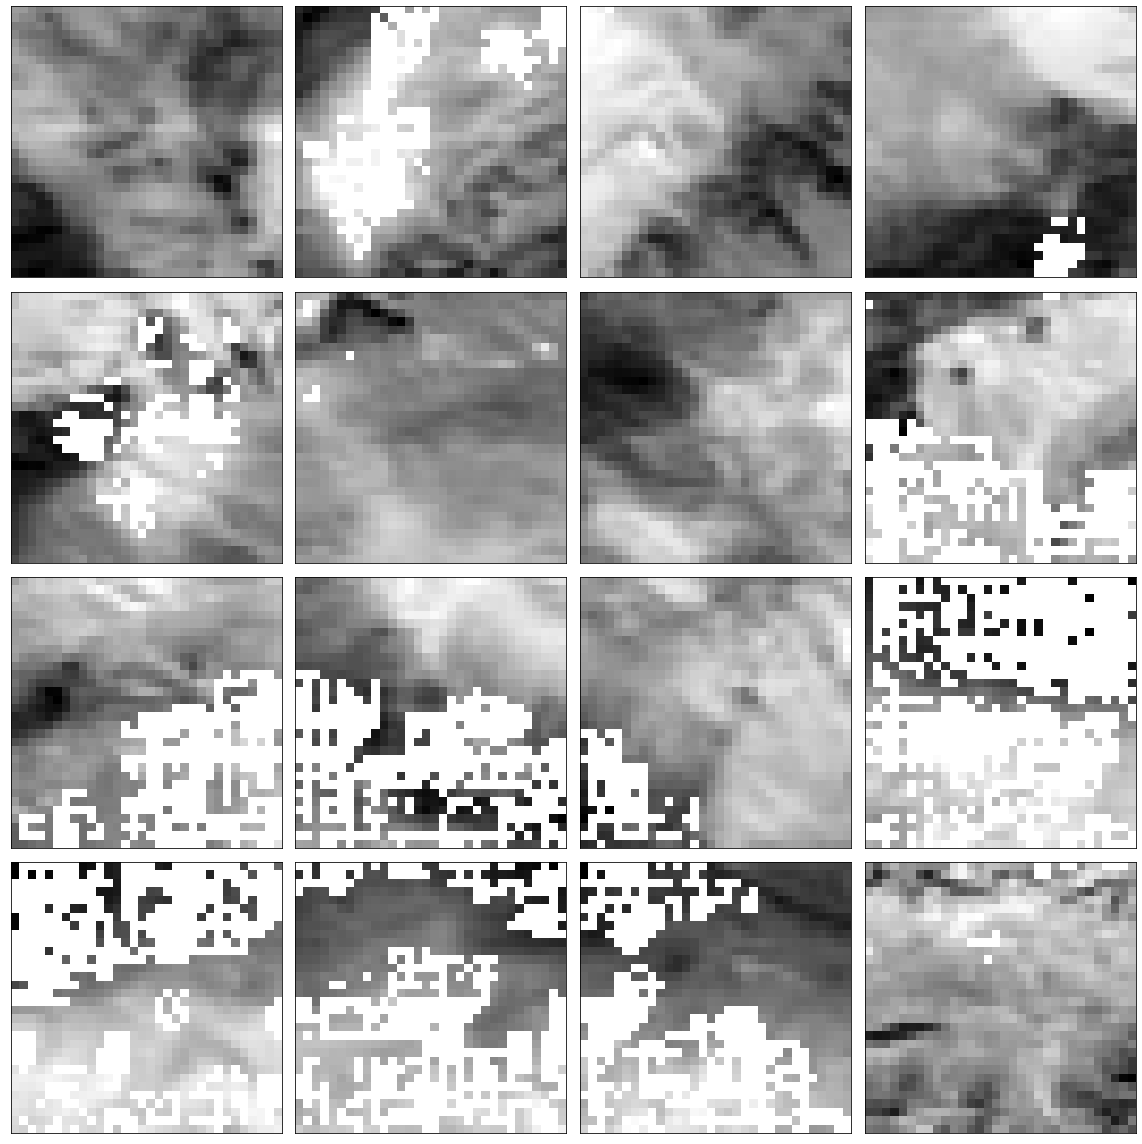

In [198]:
plotPatchesLR(np.expand_dims(X.transpose((0, 3, 4, 1, 2)), axis=0))

In [199]:
y.shape

(8240, 96, 96, 1)

In [200]:
np.expand_dims(y.transpose((0, 3, 1, 2)), axis=(0,2)).shape

(1, 8240, 1, 1, 96, 96)

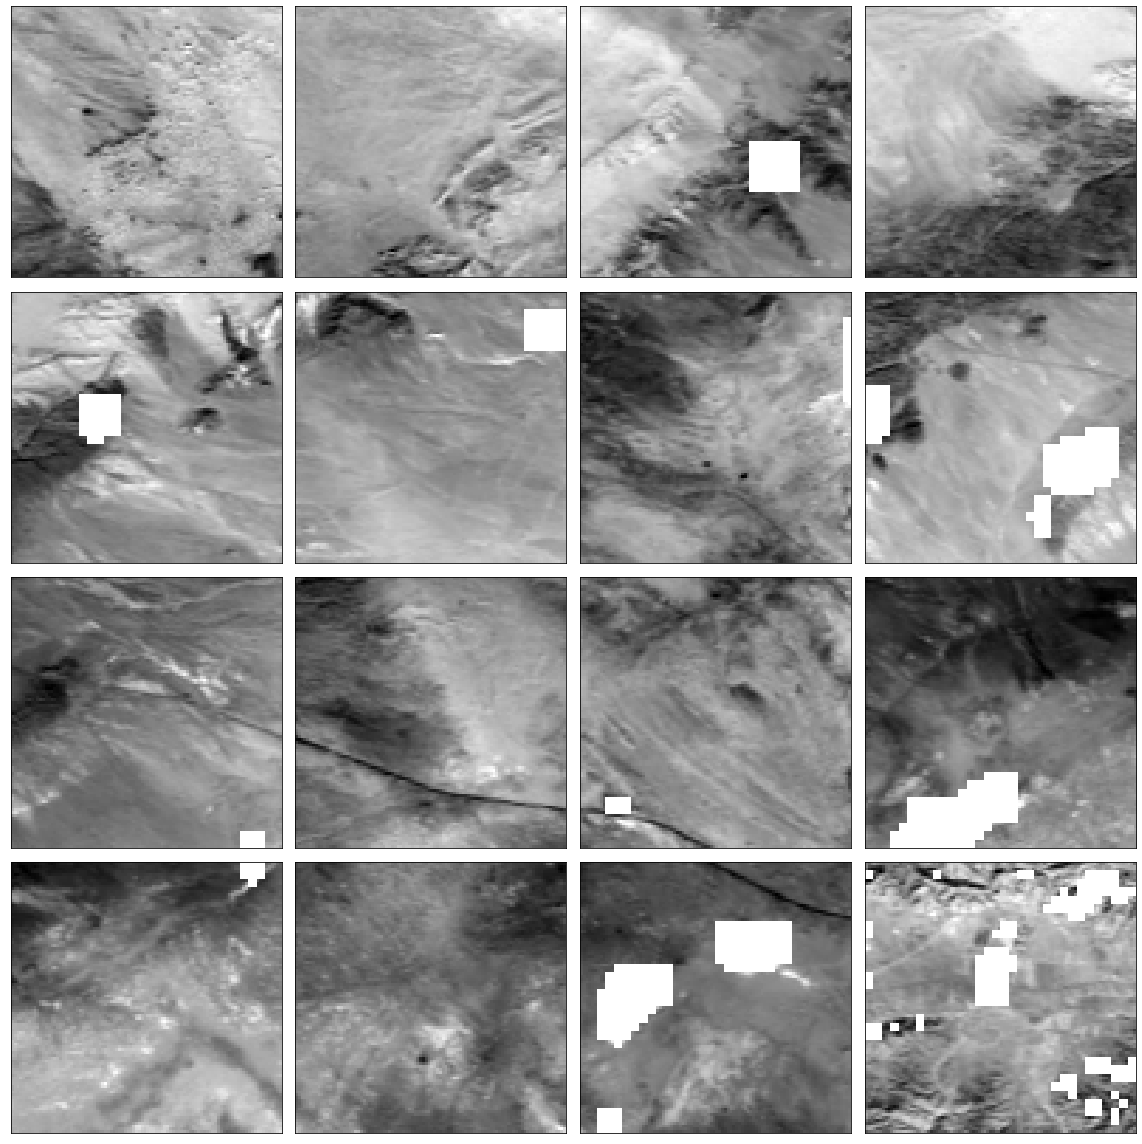

In [201]:
plotPatchesLR(np.expand_dims(y.transpose((0, 3, 1, 2)), axis=(0,2)))

In [19]:
tf.config.experimental.list_physical_devices('GPU')[0]

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [25]:
class Parser:
    def __init__(self):
        self.images = '/home/mark/DataBank/PROBA-V-CHKPT/patchesDir'
        self.modelckpt = '/home/mark/DataBank/ckptNew'
        self.output = '/home/mark/DataBank/PROBA-V-CHKPT/testout'
        self.band = 'NIR'

In [26]:
opt = Parser()

In [30]:
def main():
    X = np.load(os.path.join(opt.images, f'TESTpatchesLR_{opt.band}.npy'), allow_pickle=True)
    X = X.transpose((0, 1, 4, 5, 2, 3))
    print(X.shape)
    model = WDSRConv3D(scale=3, numFilters=32, kernelSize=(3, 3, 3), numResBlocks=8,
                       expRate=8, decayRate=0.8, numImgLR=9, patchSizeLR=32, isGrayScale=True)

    ckpt = tf.train.Checkpoint(step=tf.Variable(0),
                               psnr=tf.Variable(1.0),
                               model=model)

    ckptMngr = tf.train.CheckpointManager(checkpoint=ckpt,
                                          directory=opt.modelckpt,
                                          max_to_keep=5)

    ckpt.restore(ckptMngr.latest_checkpoint)
    y_preds = evaluate(model, X)

    band = band.upper()
    if band == 'NIR':
        i = 1306
    elif band == 'RED':
        i = 1160

    if not os.path.exists(opt.output):
        os.makedirs(opt.output)

    logging.info(f'Saving predicted images to {opt.output}')
    for img in tqdm(y_preds):
        io.imsave(os.path.join(opt.output, f'imgset{i}.png'), img[:, :, 0].astype(np.uint16))
        i += 1


def evaluate(model, X_test_patches):
    y_preds = []

    for i in tqdm(range(0, X_test_patches.shape[0])):
        # Resolve
        res_patches = resolve(model, X_test_patches[i])
        y_pred = reconstruct_from_patches(np.array(res_patches))
        y_preds.append(y_pred)
    return y_preds


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)

    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 2**16)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.float32)
    return sr_batch


def reconstruct_from_patches(images):
    rec_img = np.zeros((384, 384, 1))
    block_n = 0
    first_block = images[0, :, :, ]
    for i in range(1, 5):
        for j in range(1, 5):

            rec_img[(i-1)*96:i*96, (j-1)*96:j*96] = images[block_n, :, :, ]
            block_n += 1

    return rec_img.reshape((384, 384, 1))

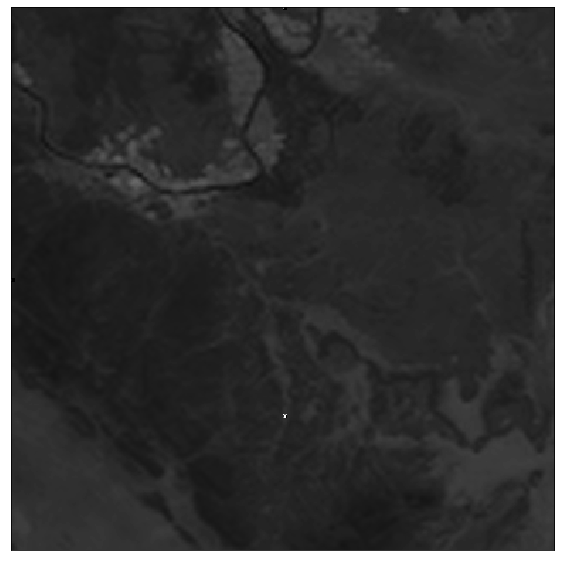

In [103]:
import matplotlib.pyplot as plt
from skimage import io
import os
import numpy as np
totest = 200
testout = '/home/mark/DataBank/PROBA-V-CHKPT/testout_patch38_top7_90p'
names = sorted(os.listdir(testout))
LR='/home/mark/DataBank/PROBA-V-CHKPT/trimmedArrayDir'
band = 'NIR'
X = np.load(os.path.join(LR, f'TESTimgLR_{band}.npy'), allow_pickle=True)
X = X.transpose((0, 3, 4, 1, 2))
x = io.imread(os.path.join(testout, names[totest]))
plot(x)

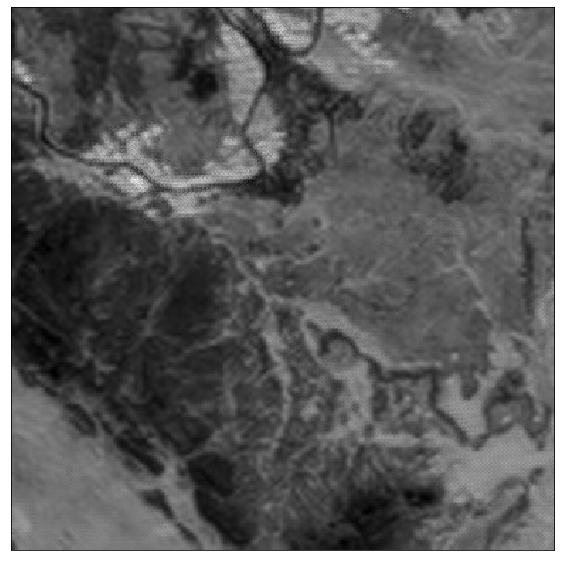

In [104]:
testout = '/home/mark/DataBank/PROBA-V-CHKPT/testout_patch38'
names = sorted(os.listdir(testout))
x = io.imread(os.path.join(testout, names[totest]))
plot(x)

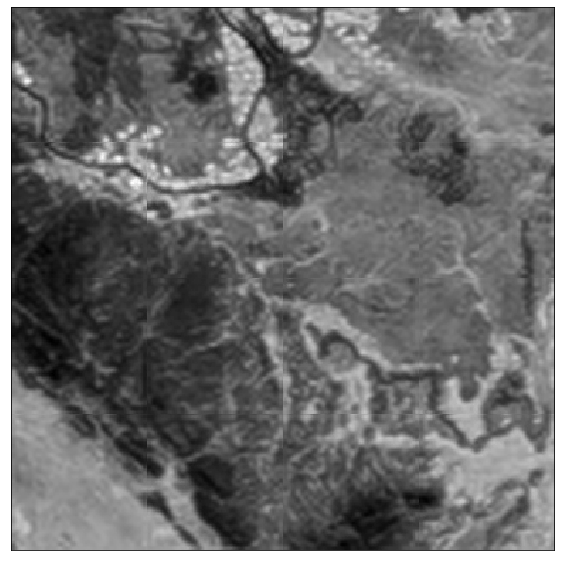

In [105]:
testout = '/home/mark/DataBank/PROBA-V-CHKPT/testout'
names = sorted(os.listdir(testout))
x = io.imread(os.path.join(testout, names[totest]))
plot(x)

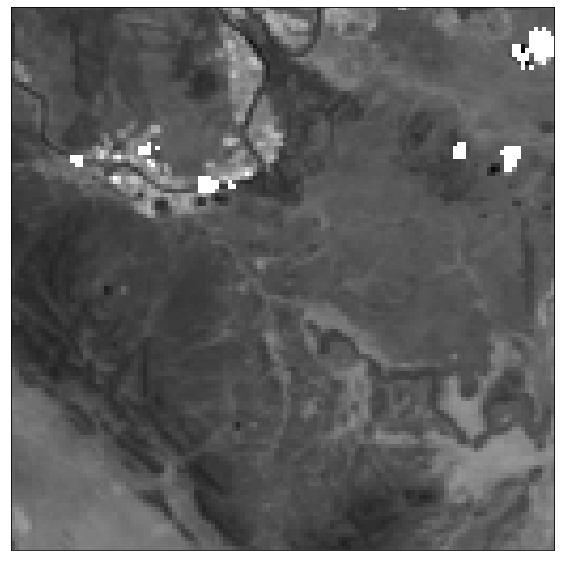

In [106]:
plot(X[totest - 146, :, : , 5, 0])

In [10]:
import os
import numpy as np
d = '/home/mark/DataBank/PROBA-V-CHKPT/trimmedArrayDir'
band = 'NIR'
patchLR = np.load(os.path.join(d, f'TRAINimgLR_{band}.npy'), allow_pickle=True)

In [2]:
import tensorflow as tf

In [3]:
patchLR = tf.convert_to_tensor(patchLR, dtype=tf.float32)

In [11]:
np.mean(patchLR)

8075.204599627321

In [ ]:
tf.math.reduce_std(patchLR)

In [12]:
np.std(patchLR)

3160.7272363774146